# Analysis of Monthly Mean Historical Hydrologic Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective analog simulation run using gridded observations -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Total Runoff
- ET

In [1]:
from loca import print_date
print_date()

Last executed: 2019-03-18 02:58:55.247226 by jvano on r6i6n30


# Imports and Options

In [21]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_historical_hydro_datasets, load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['ACCESS1-0', 'CanESM2']
#models = ['CCSM4', 'CNRM-CM5']

hydro_vars = ['ET', 'total_runoff']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.13:47288 Dashboard: proxy/8787/status,Cluster Workers: 72 Cores: 288 Memory: 360.00 GB


# Load Data

In [23]:
hydro_data = load_monthly_historical_hydro_datasets(models=models, autoclose=True, parallel=True)

load_monthly_historical_hydro_datasets
load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology
load_monthly_bcsd_hydrology
load_bcsd_dataset
load_monthly_livneh_hydrology
load_daily_livneh_hydrology
load_monthly_maurer_hydrology


In [5]:
#JAV bringing in values for ensemble

read_cache = True
hist_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [24]:
epoch = slice('1969-10-01', '1999-09-30')

mask = hydro_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, ds.sel(time=epoch).mean('time').where(mask).persist())
                   for (k, ds) in hydro_data.items())
epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in hydro_data.items())


# for debugging
# epoch_means = {}
# for k, ds in hydro_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

In [7]:
#hist_data
#hist_data['loca']['ET'].mean('gcm')
#hist_data.items()

# JAV added line below to calc ensembel average (similar to line in future hydro script except added ".mean('gcm')" and later adjusted so the chuck size was the same.
#ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS').persist().mean('time').mean('gcm').where(mask).persist())
#                  for (k, ds) in hist_data.items())

ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_data.items())

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

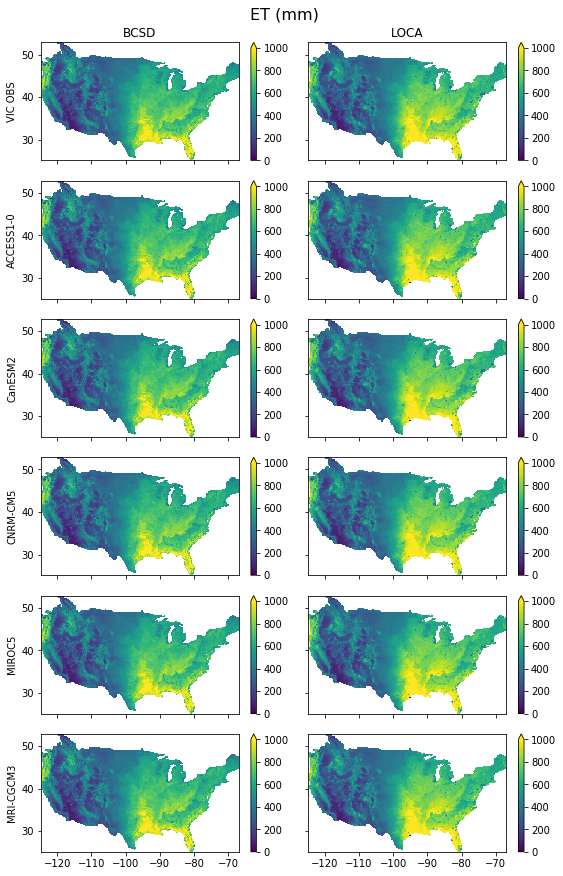

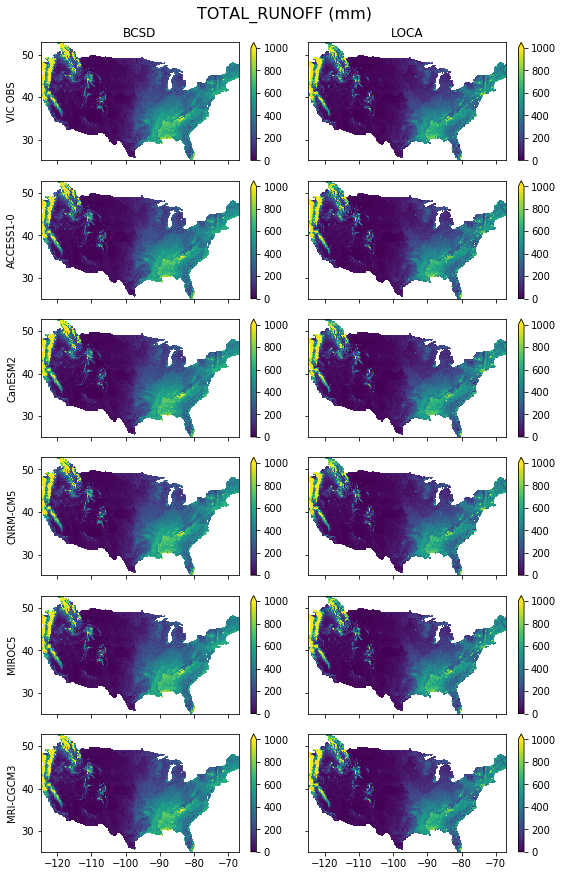

In [25]:
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000},}
units = {'ET': 'mm', 'total_runoff': 'mm'}

nrows = 1 + len(models)
ncols = 2

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('VIC OBS')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_hydro.png', dpi=300, bbox_inches='tight')

In [9]:
#ens_means['bcsd'].mean('gcm')
#hist_means['loca']['total_runoff'].mean('gcm') --> doesn't work

ens_means['bcsd']

<xarray.Dataset>
Dimensions:       (lat: 222, lon: 462)
Coordinates:
  * lat           (lat) float32 25.1875 25.3125 25.4375 ... 52.6875 52.8125
  * lon           (lon) float32 -124.6875 -124.5625 ... -67.1875 -67.0625
    time          datetime64[ns] 1950-01-16
    gcm           <U8 'CCSM4'
Data variables:
    ET            (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(100, 100)>
    total_runoff  (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(100, 100)>

In [10]:
epoch_means['maurer']

<xarray.Dataset>
Dimensions:       (lat: 222, lon: 462)
Coordinates:
  * lon           (lon) float32 -124.6875 -124.5625 ... -67.1875 -67.0625
  * lat           (lat) float32 25.1875 25.3125 25.4375 ... 52.6875 52.8125
    time          datetime64[ns] 1950-01-16
    gcm           <U8 'CCSM4'
Data variables:
    ET            (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(100, 100)>
    total_runoff  (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(100, 100)>

In [12]:
epoch_means['livneh']

<xarray.Dataset>
Dimensions:       (lat: 222, lon: 462)
Coordinates:
  * lat           (lat) float64 25.19 25.31 25.44 25.56 ... 52.56 52.69 52.81
  * lon           (lon) float64 -124.7 -124.6 -124.4 ... -67.31 -67.19 -67.06
    time          datetime64[ns] 1950-01-16
    gcm           <U8 'CCSM4'
Data variables:
    ET            (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(99, 98)>
    total_runoff  (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(99, 98)>

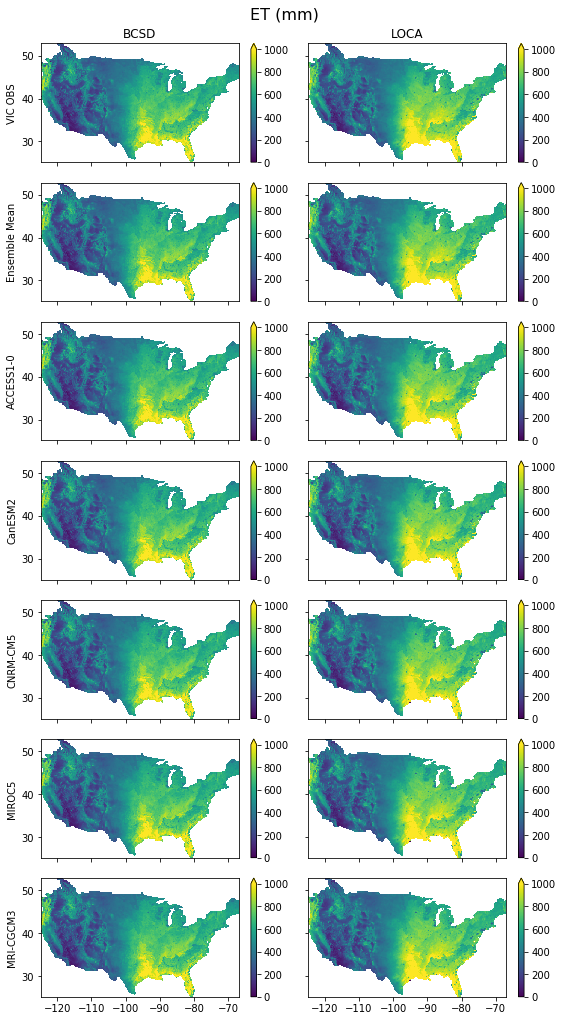

In [27]:
# JAV trying to add ensemble average
hydro_vars = ['ET']

kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000},}
units = {'ET': 'mm', 'total_runoff': 'mm'}

nrows = 2 + len(models)
ncols = 2

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ensemble, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('VIC OBS')
            
        ax = axes[1, col]
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
                
        if col == 0:
            ax.set_ylabel('Ensemble Mean')

        
        for row, model in enumerate(models, 2):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_hydro.png', dpi=300, bbox_inches='tight')

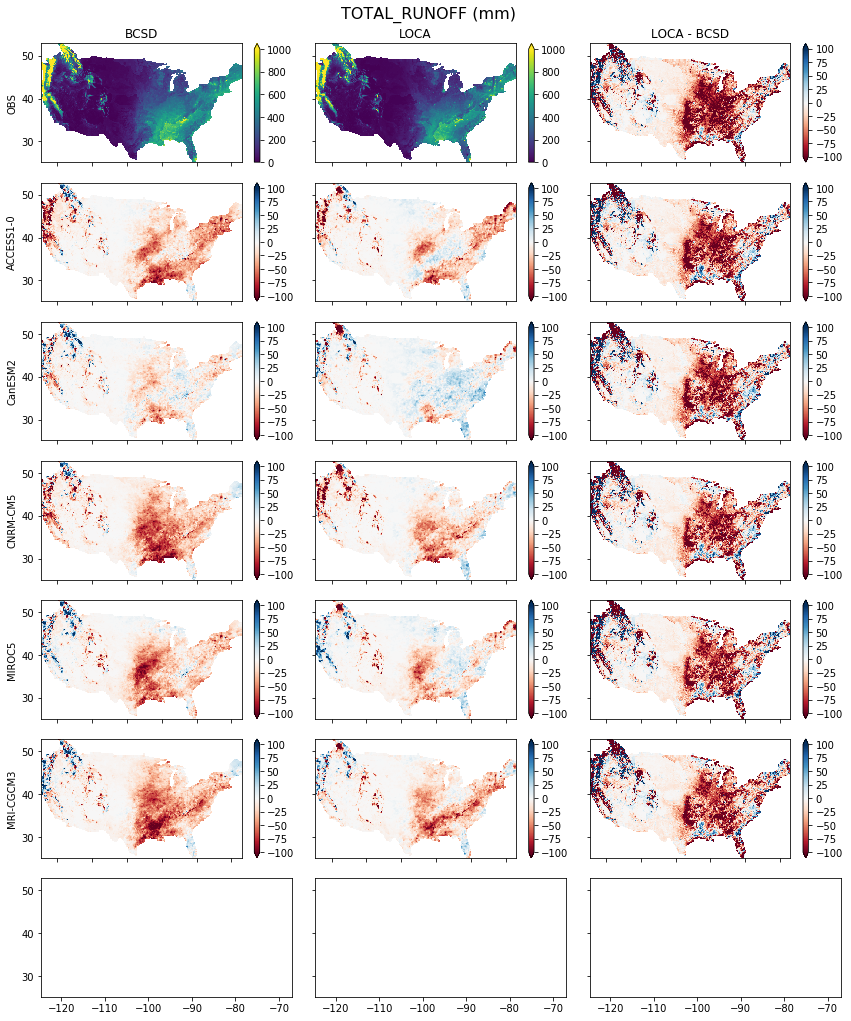

In [30]:
diff_kws = {False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}, 'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}},
            True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}, 'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}}

hydro_vars = ['total_runoff']
for var in hydro_vars:
    
    for pct in [False]:
        
        if var not in diff_kws[pct]:
            continue
    
#         fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))
#         fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
        

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
            diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_historic_hydro.png', dpi=300, bbox_inches='tight')

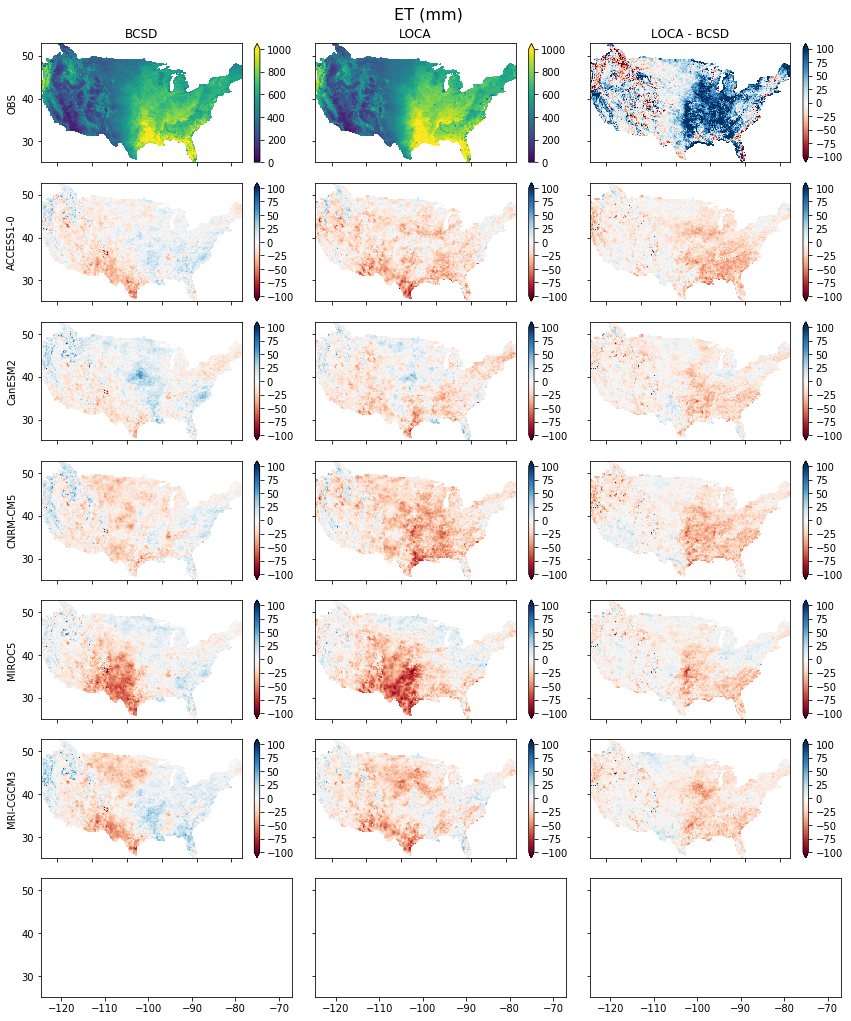

In [29]:
diff_kws = {False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}, 'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}},
            True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}, 'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}}

cache = {}

for var in hydro_vars:
    
    for pct in [False]:
        
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                cache[(row, col)] = diff.sel(gcm=model)
                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')

        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
            diff = cache[(row, 1)] - cache[(row, 0)]  #DIFF OF A DIFF JAV, right?
            diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_historic_hydro.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')

In [ ]:
print('done now okay')